# Overview of this jupyter notebook

1. Loading the data
2. Loading the optimized 1D-CNN-Model optuna TPE
3. Plotting Heatmaps with Grad-Cam

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
import pickle
import json
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.models import load_model, Model

In [3]:
import os
import importlib
from library import etl_helper as etl   # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.etl_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\etl_helper.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


# 1. Loading the data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube',
           '16_Klasse', '24_Klasse', '27_Klasse', 
           '35_Klasse', '37_Klasse', '267_Klasse', '357_Klasse']

In [6]:
feature_train = np.load("feature_label/feature_train_mlc_v2.4.npy")
feature_train.shape

(1550, 920)

In [7]:
feature_test = np.load("feature_label/feature_test_mlc_v2.4.npy")
feature_test.shape

(750, 920)

In [8]:
label_train = np.load("feature_label/label_train_mlc_v2.4.npy")
label_train.shape

(1550, 8)

In [9]:
label_test = np.load("feature_label/label_test_mlc_v2.4.npy")
label_test.shape

(750, 8)

In [10]:
x_train = feature_train
x_test = feature_test

y_train = label_train
y_test = label_test.astype(int)

In [11]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]])

In [12]:
max_train = np.load("dataframes/max_train.npy")
max_train

array(2.56704)

In [13]:
x_train_inverse = x_train * max_train
x_test_inverse = x_test * max_train

In [14]:
len_curve = 920
x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)

x_train.shape, x_test.shape

((1550, 920, 1), (750, 920, 1))

# 2. Loading the optimized 1D-CNN-Model optuna TPE

In [15]:
model = load_model('model/mlc_cnn_optuna_tpesampler_v2.4.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 913, 64)           576       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 228, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 221, 64)           32832     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 55, 64)           0         
 g1D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 55, 64)           256       
 chNormalization)                                                
                                                      

In [16]:
prediction = model.predict(x_test)
y_pred = ch.make_pred_mlc(prediction, threshold=0.5)
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.9506666666666667
hamming loss: 0.007666666666666666

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.990     0.980     0.985       100
           2      0.974     0.955     0.965       200
           3      0.995     0.990     0.992       200
           4      0.948     0.920     0.934       100
           5      0.993     0.987     0.990       150
           6      1.000     0.960     0.980       150
           7      0.992     0.992     0.992       250

   micro avg      0.987     0.974     0.981      1200
   macro avg      0.987     0.973     0.980      1200
weighted avg      0.987     0.974     0.981      1200
 samples avg      0.987     0.978     0.980      1200



In [17]:
mismatch = []

for i,lab in enumerate(zip(y_test, y_pred)):
    if np.array_equal(lab[0], lab[1])==False:
        print(lab[0], lab[1])
        mismatch.append(i)

[0 1 0 0 0 0 0 0] [0 1 1 0 0 0 0 0]
[0 0 1 0 0 0 0 0] [0 1 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0] [0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 0 0] [0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 0 0] [0 0 1 0 0 1 0 0]
[0 0 0 0 1 0 0 0] [0 0 1 0 1 0 0 0]
[0 0 0 0 1 0 0 0] [0 0 1 0 1 0 0 0]
[0 0 0 0 1 0 0 0] [0 0 1 0 1 0 0 0]
[0 0 0 0 0 1 0 0] [0 0 0 0 0 0 0 1]
[0 0 0 0 0 1 0 0] [0 0 0 1 0 1 0 0]
[0 1 0 0 0 0 1 0] [0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 1 0] [0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 1 0] [0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 1 0] [0 1 1 0 0 0 0 0]
[0 1 0 0 0 0 1 0] [0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 1 0] [0 1 0 0 0 0 0 0]
[0 1 0 0 0 0 1 0] [0 0 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0] [0 0 0 0 1 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 1 0 0 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 1 0 0 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 0 0 1 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 0 0 1 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 1 0 0 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 0 0 0 0 0 1]
[0 0 1 0 1 0 0 0] [0 0 1 0 0 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 0 0 1 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 1 0 0 0 0 0]
[0 0 1 0 1 0 0 0] [0 0 0 0 1

In [18]:
mismatch

[93,
 103,
 122,
 138,
 149,
 210,
 217,
 248,
 258,
 273,
 403,
 410,
 413,
 418,
 421,
 422,
 434,
 453,
 454,
 455,
 458,
 461,
 465,
 466,
 468,
 473,
 475,
 476,
 483,
 487,
 488,
 491,
 539,
 547,
 555,
 574,
 705]

In [22]:
# matching curve nr to each classes in the test data

class_sector = [x*50 for x in range(16)]

for i,cl in enumerate(zip(classes, class_sector)):
    print(f"{cl[0]}: {cl[1]} - {cl[1]+49}")

0_in_ordnung: 0 - 49
1_kleine_durchgangsbohrung: 50 - 99
2_versetzte_fuegepartner: 100 - 149
3_unebene_fuegeflaeche: 150 - 199
4_span_im_gewinde: 200 - 249
5_verschmutzte_schraube: 250 - 299
6_fremdkoerper_am_gewindeende: 300 - 349
7_beschaedigte_schraube: 350 - 399
16_Klasse: 400 - 449
24_Klasse: 450 - 499
27_Klasse: 500 - 549
35_Klasse: 550 - 599
37_Klasse: 600 - 649
267_Klasse: 650 - 699
357_Klasse: 700 - 749


# 3. Plotting Heatmaps with Grad-Cam

In [19]:
def create_heatmap(grad_model, curve, label):
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(curve)
        loss = preds[:, label]
               
    grads = tape.gradient(loss, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0))
    
    heatmap = last_conv_layer_output[0] * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    
    return heatmap

In [20]:
# Defining the Grad-CAM algorithm

def grad_cam(model, last_conv_layer, xtest, ytest):
    
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])
    
    heatmaps = np.zeros([750, 3, 48])
    
    for i,data in enumerate(zip(xtest, ytest)):
        
        for j,lab in enumerate(np.where(data[1]==1)[0]):
            curve = np.expand_dims(data[0], 0)
            heatmap = create_heatmap(grad_model, curve, lab)
            heatmaps[i,j,:] = heatmap

    return heatmaps

In [61]:
# name of last convolutional layer is "conv1d_17"

heatmaps = grad_cam(model, "conv1d_17", x_test, y_test)
heatmaps.shape

(750, 3, 48)

In [69]:
heatmaps[650]

array([[ 3.72194608e-09,  4.95583308e-09,  1.38989120e-09,
         2.47607757e-09,  3.34737071e-10,  3.44932816e-09,
         5.54519930e-10, -1.09803244e-09,  1.66219882e-09,
         1.32064393e-09,  8.15163881e-10, -2.05255424e-10,
         2.30959563e-09, -1.36459943e-09,  5.91629745e-10,
         1.66952646e-10,  8.56014482e-10, -7.75070397e-10,
         2.29594166e-09,  2.06737116e-09,  1.88046842e-10,
         4.71980233e-10,  1.15207732e-09,  1.70305303e-09,
         1.54984114e-09,  1.38833070e-10,  2.23672281e-09,
         1.26471855e-09,  4.17774787e-10,  4.96195862e-11,
         9.75104025e-11,  8.04560973e-10,  1.14253607e-11,
        -3.44102913e-10,  8.20795376e-10, -9.25126364e-10,
         8.37427294e-10,  2.46485121e-09,  1.43889434e-09,
         2.99777714e-09,  5.55791813e-09,  1.11251133e-10,
         3.91437022e-10, -3.29533068e-10,  6.58145372e-10,
         1.47728318e-09,  1.30431319e-10,  6.01190475e-09],
       [ 1.70952308e-09,  2.32912378e-09, -2.02811723e-

In [63]:
#np.save("results/mlc_cnn_optuna_tpe_gradcam_heatmap_v2.4.npy", heatmaps)

In [21]:
heatmaps = np.load("results/mlc_cnn_optuna_tpe_gradcam_heatmap_v2.4.npy")
heatmaps.shape

(750, 3, 48)

In [22]:
for i,maps in enumerate(heatmaps[:50]):
    if maps[0].sum()>0:
        print(i)

5
7
11
14
21
25
28
32
33
35
38
40
41
43


In [23]:
def check_mismatch(xtest_index, mismatch):
    if xtest_index in mismatch:
        print("### mismatch ###")

In [24]:
def plot_heatmaps1(heatmaps, xtest, xtest_index, label, color=fapsc.black, figsize=(10,3), dpi=80):
    
    plt.rcParams['font.family'] = ['Arial']
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(np.expand_dims(heatmaps[xtest_index][0],axis=0), cmap="Greens", aspect="auto", interpolation='nearest', 
               extent=[0,etl.set_time(xtest[xtest_index])[-1], -0.3, xtest.max()], alpha=0.7)
    
    plt.plot(etl.set_time(xtest[xtest_index]), xtest[xtest_index], label=label, color=color, linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(loc='upper left', fontsize=16)
    plt.show()        

In [25]:
def plot_heatmaps2(heatmaps, xtest, xtest_index, label, color=fapsc.black, figsize=(10,3), dpi=80):
    
    plt.rcParams['font.family'] = ['Arial']
    plt.figure(figsize=figsize, dpi=dpi)
    
    y_range = xtest.max()-0.3
    
    plt.imshow(np.expand_dims(heatmaps[xtest_index][0], axis=0), cmap="Greens", aspect="auto", interpolation='nearest', 
               extent=[0,etl.set_time(xtest[xtest_index])[-1], y_range/2, xtest.max()], alpha=0.7)
    
    plt.imshow(np.expand_dims(heatmaps[xtest_index][1], axis=0), cmap="Blues", aspect="auto", interpolation='nearest', 
               extent=[0,etl.set_time(xtest[xtest_index])[-1], -0.3, y_range/2], alpha=0.7)
    
    plt.plot(etl.set_time(xtest[xtest_index]), xtest[xtest_index], label=label, color=color, linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(loc='upper left', fontsize=16)
    plt.show()  

In [26]:
def plot_heatmaps3(heatmaps, xtest, xtest_index, label, color=fapsc.black, figsize=(10,3), dpi=80):
    
    plt.rcParams['font.family'] = ['Arial']
    plt.figure(figsize=figsize, dpi=dpi)
    
    y_min = -0.3
    y_max = xtest.max()-(y_min)
    y_third = y_max/3
    
    plt.imshow(np.expand_dims(heatmaps[xtest_index][0], axis=0), cmap="Greens", aspect="auto", interpolation='nearest', 
               extent=[0,etl.set_time(xtest[xtest_index])[-1], y_max-y_third+y_min, y_max+y_min], alpha=0.7)
    
    plt.imshow(np.expand_dims(heatmaps[xtest_index][1], axis=0), cmap="Blues", aspect="auto", interpolation='nearest', 
               extent=[0,etl.set_time(xtest[xtest_index])[-1], y_min+y_third, y_max-y_third+y_min], alpha=0.7)
    
    plt.imshow(np.expand_dims(heatmaps[xtest_index][2], axis=0), cmap="Reds", aspect="auto", interpolation='nearest', 
               extent=[0,etl.set_time(xtest[xtest_index])[-1], y_min, y_min+y_third], alpha=0.7)
    
    plt.plot(etl.set_time(xtest[xtest_index]), xtest[xtest_index], label=label, color=color, linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(loc='upper left', fontsize=16)
    plt.show()  

In [27]:
def plot_gradcam(heatmaps, xtest, xtest_index, mismatch, label, color=fapsc.black, figsize=(10,3), dpi=80):
    
    check_mismatch(xtest_index, mismatch)
    
    if xtest_index<400:
        plot_heatmaps1(heatmaps, xtest, xtest_index, label, color=fapsc.black, figsize=figsize, dpi=dpi)
        
    elif (xtest_index>=400) & (xtest_index<650):
        plot_heatmaps2(heatmaps, xtest, xtest_index, label, color=fapsc.black, figsize=figsize, dpi=dpi)
        
    else:
        plot_heatmaps3(heatmaps, xtest, xtest_index, label, color=fapsc.black, figsize=figsize, dpi=dpi)
        

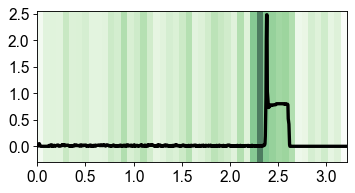

In [35]:
plot_gradcam(heatmaps, x_test_inverse, 21, mismatch, label="", color=fapsc.black, figsize=(5,2.5), dpi=80)

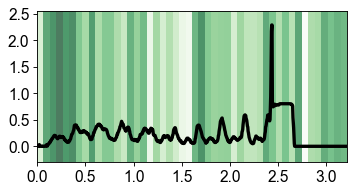

In [57]:
plot_gradcam(heatmaps, x_test_inverse, 120, mismatch, label="", color=fapsc.black, figsize=(5,2.5), dpi=80)

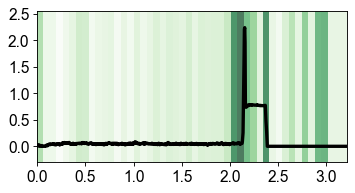

In [58]:
plot_gradcam(heatmaps, x_test_inverse, 154, mismatch, label="", color=fapsc.black, figsize=(5,2.5), dpi=80)

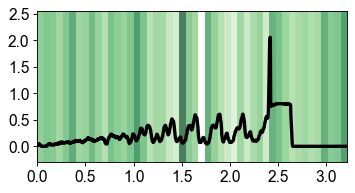

In [59]:
plot_gradcam(heatmaps, x_test_inverse, 222, mismatch, label="", color=fapsc.black, figsize=(5,2.5), dpi=80)

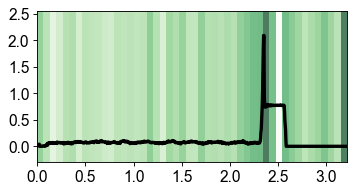

In [60]:
plot_gradcam(heatmaps, x_test_inverse, 275, mismatch, label="", color=fapsc.black, figsize=(5,2.5), dpi=80)

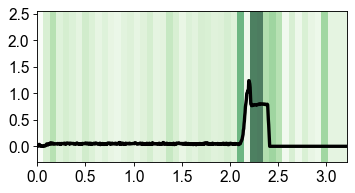

In [65]:
plot_gradcam(heatmaps, x_test_inverse, 303, mismatch, label="", color=fapsc.black, figsize=(5,2.5), dpi=80)

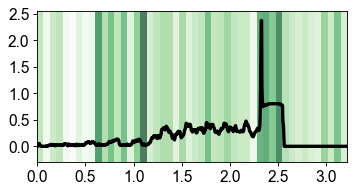

In [66]:
plot_gradcam(heatmaps, x_test_inverse, 370, mismatch, label="", color=fapsc.black, figsize=(5,2.5), dpi=80)

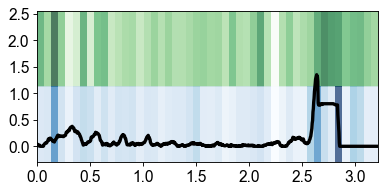

In [193]:
plot_gradcam(heatmaps, x_test_inverse, 443, mismatch, label="", color=fapsc.black, figsize=(5.5,2.5), dpi=80)

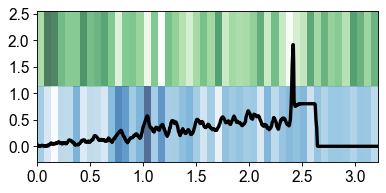

In [194]:
plot_gradcam(heatmaps, x_test_inverse, 462, mismatch, label="", color=fapsc.black, figsize=(5.5,2.5), dpi=80)

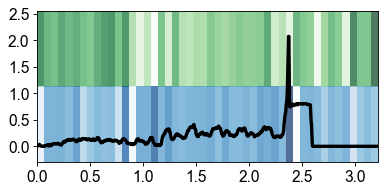

In [195]:
plot_gradcam(heatmaps, x_test_inverse, 514, mismatch, label="", color=fapsc.black, figsize=(5.5,2.5), dpi=80)

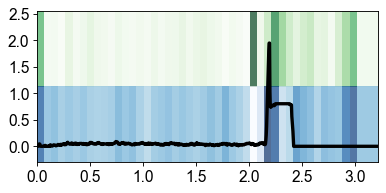

In [197]:
plot_gradcam(heatmaps, x_test_inverse, 550, mismatch, label="", color=fapsc.black, figsize=(5.5,2.5), dpi=80)

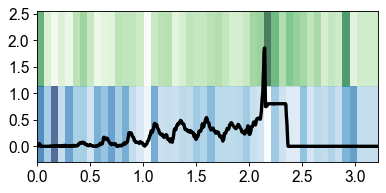

In [249]:
plot_gradcam(heatmaps, x_test_inverse, 647, mismatch, label="", color=fapsc.black, figsize=(5.5,2.5), dpi=80)

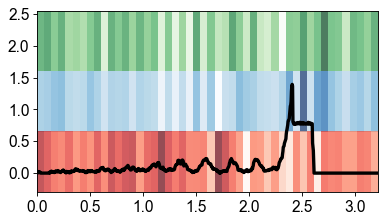

In [145]:
plot_gradcam(heatmaps, x_test_inverse, 659, mismatch, label="", color=fapsc.black, figsize=(5.5,3), dpi=80)

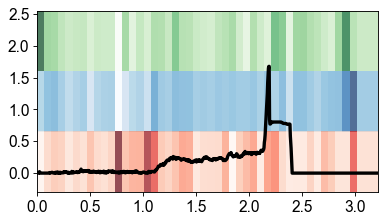

In [146]:
plot_gradcam(heatmaps, x_test_inverse, 724, mismatch, label="", color=fapsc.black, figsize=(5.5,3), dpi=80)

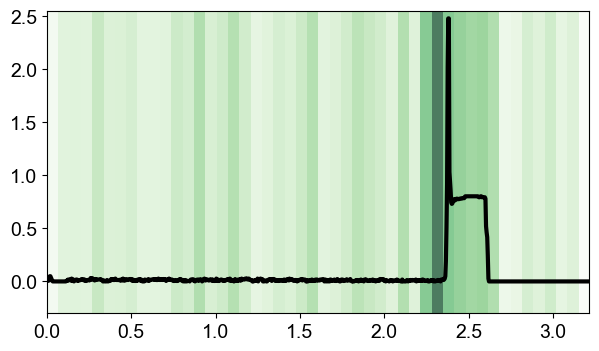

In [28]:
plot_gradcam(heatmaps, x_test_inverse, 21, mismatch, label="", color=fapsc.black, figsize=(7,4), dpi=100)

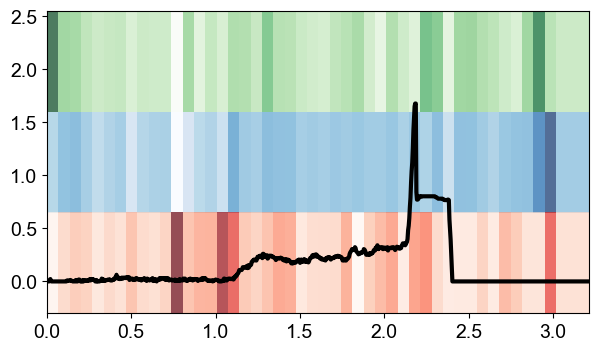

In [29]:
plot_gradcam(heatmaps, x_test_inverse, 724, mismatch, label="", color=fapsc.black, figsize=(7,4), dpi=100)